In [79]:
import pandas as pd
import numpy as np
from numpy.ma.extras import average
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

customer = pd.read_csv("Customer.csv")
countryPopulation = pd.read_csv("CountryPopulation.csv")
countryGDP = pd.read_csv("CountryGDP.csv")


# Devoir 2 - 8IAR403
Étudiant : *Mael Garnier*

Le plan reprend l'ordre des questions du sujet.

## 1. Préparation

### 1.1 Pipeline de transformation

Nous avions déjà réalisé le pipeline de transformation lors du devoir 1. Nous allons donc le réutiliser ici.

Tout le code suivant est une copie condensée du code du devoir 1.

In [80]:
from sklearn.compose import make_column_selector
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder


def replace_missing_values_function(X, cols_to_numeric, cols_to_exclude):
    for col in cols_to_numeric:
        if col in X.columns and X[col] is not None:
            X[col] = pd.to_numeric(X[col], errors='coerce')

    imputer = SimpleImputer(strategy="median")
    x_num = X.drop(columns=cols_to_exclude, axis=1)
    imputer.fit(x_num)
    x_num_tr = imputer.transform(x_num)
    x_tr = pd.DataFrame(x_num_tr, columns=x_num.columns,
                          index=X.index)
    x_tr[cols_to_exclude] = X[cols_to_exclude]
    return x_tr
replace_missing_values_customer = FunctionTransformer(
    replace_missing_values_function,
    validate=False,
    kw_args={
        "cols_to_numeric": ["first_item_prize", "revenue"],
        "cols_to_exclude": ["gender", "ReBuy", "country"]
    }
)
def replace_outliers_with_interpolation_function(X, cols_to_exclude):
    x_num = X.drop(columns=cols_to_exclude, axis=1)
    Q1 = x_num.quantile(0.25)
    Q3 = x_num.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    for column in x_num.columns:
        x_num[column] = np.where(
            (x_num[column] < lower_bound[column]) | (x_num[column] > upper_bound[column]),
            np.nan,
            x_num[column]
        )
        x_num[column] = x_num[column].interpolate(method='slinear', limit_direction='both')
    x_num[cols_to_exclude] = X[cols_to_exclude]
    return x_num
replace_outliers_customer = FunctionTransformer(
    replace_outliers_with_interpolation_function,
    validate=False,
    kw_args={
        "cols_to_exclude": ["gender", "ReBuy", "country", "age"]
    }
)
def data_enrichment_function(X, addPIB):
    new_countryPopulation = replace_missing_values_function(countryPopulation, cols_to_numeric=[], cols_to_exclude=["Country"])
    new_countryPopulation.rename(columns={'Country': 'country'}, inplace=True)
    X['country'] = X['country'].str.lower()
    new_countryPopulation['country'] = new_countryPopulation['country'].str.lower()
    merged_df = pd.merge(X, new_countryPopulation, on='country', how='left')
    if addPIB :
        new_countryGDP = replace_missing_values_function(countryGDP, cols_to_numeric=[], cols_to_exclude=["Country"])
        new_countryGDP.rename(columns={'Country': 'country'}, inplace=True)
        new_countryGDP['country'] = new_countryGDP['country'].str.lower()
        merged_df = pd.merge(merged_df, new_countryGDP, on='country', how='left')
    return merged_df
data_enrichment = FunctionTransformer(
    data_enrichment_function,
    validate=False,
    kw_args={
        "addPIB": True
    },
)
data_enrichment_nopib = FunctionTransformer(
    data_enrichment_function,
    validate=False,
    kw_args={
        "addPIB": False
    },
)
data_cleaning = Pipeline([
    ("replace_missing", replace_missing_values_customer),
    ("replace_outliers", replace_outliers_customer),
])
def remove_non_numeric_columns(arr):
        df = pd.DataFrame(arr)
        for col in df.columns:
            try:
                df[col] = pd.to_numeric(df[col])
            except ValueError:
                df.drop(columns=[col], inplace=True)
        return df.to_numpy()
def prepare_customer(X):
    full_pipeline = ColumnTransformer(
        transformers=[
            ("cleaning", data_cleaning, X.columns),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False), make_column_selector(dtype_include=np.number))
        ],
        remainder="drop"
    )
    res = full_pipeline.fit_transform(X)
    return remove_non_numeric_columns(res)
def prepare_customer_pop(X):
    full_pipeline = ColumnTransformer(
        transformers=[
            ("cleaning", data_cleaning, X.columns),
            ("enrichment", data_enrichment_nopib, X.columns),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False), make_column_selector(dtype_include=np.number))
        ],
        remainder="drop"
    )
    res = full_pipeline.fit_transform(X)
    return remove_non_numeric_columns(res)
def prepare_customer_pop_gdp(X):
    full_pipeline = ColumnTransformer(
        transformers=[
            ("cleaning", data_cleaning, X.columns),
            ("enrichment", data_enrichment, X.columns),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False), make_column_selector(dtype_include=np.number))
        ],
        remainder="drop"
    )
    res = full_pipeline.fit_transform(X)
    return remove_non_numeric_columns(res)

### 1.2. Séparation des données

Nous allons séparer les données en données d'entrainement et données de test.

In [81]:
train_set, test_set = train_test_split(customer, test_size=0.2,
                                       random_state=5)

## 2. Entrainement d'un classeur binaire

### 2.1
Nous allons préparer les données d'entrainement. Commencons par isoler la classe binaire.

In [82]:
# Remplacement des valeurs manquantes sur le jeu de données pour préparer la classe
train_set_corrected = replace_missing_values_function(train_set, ["first_item_prize", "revenue"], ["gender", "ReBuy", "country"])
# Calcul de la moyenne des revenus depuis le jeu de données corrigé
revenue_mean = train_set_corrected["revenue"].mean()
# Création de la classe binaire, 1 si le revenu est supérieur à la moyenne, 0 sinon
customer_labels = (train_set_corrected["revenue"] > revenue_mean).astype(int)

customer_labels.head()

7751    1
4154    0
3881    0
9238    1
5210    0
Name: revenue, dtype: int64

On peut voir que la classe a bien été préparée avec des valeurs binaires : 0 si le revenu est inférieur à la moyenne, 1 sinon.

### 2.2
Nous pouvons maintenant préparer les données d'entrainement avec le pipeline, en prenant soin de retirer la classe binaire.

Nous allons créer 3 sets de données : uniquement à partir du dataframe customer, le dataframe customer et population, et enfin dataframe customer, population et gdp.

In [83]:
# Préparation des données d'entrainement
customer_train = resample(train_set, replace=False, n_samples=8000, random_state=42)
customer_train = customer_train.drop("revenue", axis=1)

# Traitement des données avec le pipeline

# Uniquement customer
customer_prepare = prepare_customer(customer_train)
# customer + population
customer_pop_prepare = prepare_customer_pop(customer_train)
# customer + population + gdp
customer_pop_gdp_prepare = prepare_customer_pop_gdp(customer_train)


### 2.3

Nous allons entrainer un modèle : DecisionTreeClassifier.

In [84]:
# Entrainement du modèle
tree_class_customer  = DecisionTreeClassifier()
tree_class_customer_pop  = DecisionTreeClassifier()
tree_class_customer_pop_gdp  = DecisionTreeClassifier()
tree_class_customer.fit(customer_prepare, customer_labels)
tree_class_customer_pop.fit(customer_pop_prepare, customer_labels)
tree_class_customer_pop_gdp.fit(customer_pop_gdp_prepare, customer_labels)

DecisionTreeClassifier()

### 2.4
Maintenant que le modèle est créé et entrainé, nous pouvons calculer la precision, le rappel et la F1-mesure avec de la validation croisée.

Nous allons tester pour chacun des trois dataset deux valeurs de K : 3 et 10.

In [85]:
res_dict = {
    "crossval": {
        "k3": {},
        "k10": {}
    },
    "gridsearch": {
        "k3": {},
        "k10": {}
    },
    "test": {}
}

# Fonction pour calculer la précision, le rappel et la F1-mesure dans le cadre de la validation croisée
def cross_val_classification_metrics(classifier, X, y, cv=3):
    # Définir les scores personnalisés
    precision_scorer = make_scorer(precision_score, average = "weighted")
    recall_scorer = make_scorer(recall_score, average = "weighted")
    f1_scorer = make_scorer(f1_score, average = "weighted")

    # Validation croisée avec précision
    precision_scores = cross_val_score(classifier, X, y, scoring=precision_scorer, cv=cv)
    print(f"Précision (k={cv}): {precision_scores.mean()} ± {precision_scores.std()}")

    # Validation croisée avec rappel
    recall_scores = cross_val_score(classifier, X, y, scoring=recall_scorer, cv=cv)
    print(f"Rappel (k={cv}): {recall_scores.mean()} ± {recall_scores.std()}")

    # Validation croisée avec F1-mesure
    f1_scores = cross_val_score(classifier, X, y, scoring=f1_scorer, cv=cv)
    print(f"F1-mesure (k={cv}): {f1_scores.mean()} ± {f1_scores.std()}")

    return {
        "precision": float(precision_scores.mean()),
        "recall": float(recall_scores.mean()),
        "f1": float(f1_scores.mean()),
    }

# Evaluation du modèle pour chaque ensemble de données avec k=3 et k=10
print("Évaluation avec k=3")

# Evaluation pour les différentes configurations de données
print("\nCustomer (k=3):")
res_dict["crossval"]["k3"]["customer"] = cross_val_classification_metrics(tree_class_customer, customer_prepare, customer_labels, cv=3)

print("\nCustomer + Population (k=3):")
res_dict["crossval"]["k3"]["customer + population"] = cross_val_classification_metrics(tree_class_customer_pop, customer_pop_prepare, customer_labels, cv=3)

print("\nCustomer + Population + GDP (k=3):")
res_dict["crossval"]["k3"]["customer + population + gdp"] = cross_val_classification_metrics(tree_class_customer_pop_gdp, customer_pop_gdp_prepare, customer_labels, cv=3)

print("\nÉvaluation avec k=10")

print("\nCustomer (k=10):")
res_dict["crossval"]["k10"]["customer"] = cross_val_classification_metrics(tree_class_customer, customer_prepare, customer_labels, cv=10)

print("\nCustomer + Population (k=10):")
res_dict["crossval"]["k10"]["customer + population"] = cross_val_classification_metrics(tree_class_customer_pop, customer_pop_prepare, customer_labels, cv=10)

print("\nCustomer + Population + GDP (k=10):")
res_dict["crossval"]["k10"]["customer + population + gdp"] = cross_val_classification_metrics(tree_class_customer_pop_gdp, customer_pop_gdp_prepare, customer_labels, cv=10)

Évaluation avec k=3

Customer (k=3):
Précision (k=3): 0.5340386246474341 ± 0.005738331849052394
Rappel (k=3): 0.5387497042989656 ± 0.00634733629271353
F1-mesure (k=3): 0.5352227803818687 ± 0.0068544796285405305

Customer + Population (k=3):
Précision (k=3): 0.5223597455300357 ± 0.004214451886618206
Rappel (k=3): 0.5222501725918919 ± 0.00771571895970757
F1-mesure (k=3): 0.5237612406606355 ± 0.007734002809609957

Customer + Population + GDP (k=3):
Précision (k=3): 0.5224094534684651 ± 0.007506729617913204
Rappel (k=3): 0.5219990786973083 ± 0.008040658153702484
F1-mesure (k=3): 0.5259310531169621 ± 0.007885440172464805

Évaluation avec k=10

Customer (k=10):
Précision (k=10): 0.5231796957555119 ± 0.012091861042046712
Rappel (k=10): 0.5278750000000001 ± 0.013761926645640863
F1-mesure (k=10): 0.5294539008476051 ± 0.014576336564845306

Customer + Population (k=10):
Précision (k=10): 0.521405476376488 ± 0.012810088855569553
Rappel (k=10): 0.5217499999999999 ± 0.010828203913853867
F1-mesure (k

En comparant les résultats pour k=3 et k=10, bien que les valeurs soient très proche, nous pouvons observer que k=3 semble afficher de meilleurs résultats.

Ce sera donc notre choix pour la partie suivante.

### 2.5
Maintenant, nous pouvons chercher à optimiser les hyper paramètres en utilisant la recherche par quadrillage.
Nous allons nous concentrer sur deux : la profondeur de l'arbre (max_depth) et le nombre minimal d'observations pour la segmentation d'un nœud (min_samples_split).

In [86]:
# Définir l'intervalle des hyperparamètres à tester
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, None],  # Profondeur de l'arbre
    'min_samples_split': [2, 5, 10, 20]   # Nombre minimal d'observations pour une division
}

# Création du modèle d'arbre de décision
tree_class = DecisionTreeClassifier(random_state=42)

# Initialisation de GridSearchCV avec la validation croisée de k=3 blocs
grid_search = GridSearchCV(estimator=tree_class, param_grid=param_grid, cv=3, scoring='accuracy')

def grid_search_function(numpy, labels):
    grid_search.fit(numpy, labels)
    # Meilleurs paramètres trouvés
    print("Meilleurs paramètres trouvés : ", grid_search.best_params_)
    # Meilleurs scores
    print("Meilleur score (accuracy) : ", grid_search.best_score_)
    return {
        "params": grid_search.best_params_,
        "score": float(grid_search.best_score_),
    }

print("Customer")
res_dict["gridsearch"]["k3"]["customer"] = grid_search_function(customer_prepare, customer_labels)

print("\nCustomer + Population")
res_dict["gridsearch"]["k3"]["customer + population"] = grid_search_function(customer_pop_prepare, customer_labels)

print("\nCustomer + Population + GDP")
res_dict["gridsearch"]["k3"]["customer + population + gdp"] = grid_search_function(customer_pop_gdp_prepare, customer_labels)

Customer
Meilleurs paramètres trouvés :  {'max_depth': 3, 'min_samples_split': 2}
Meilleur score (accuracy) :  0.6089997846293219

Customer + Population
Meilleurs paramètres trouvés :  {'max_depth': 3, 'min_samples_split': 2}
Meilleur score (accuracy) :  0.6095000503031645

Customer + Population + GDP
Meilleurs paramètres trouvés :  {'max_depth': 3, 'min_samples_split': 2}
Meilleur score (accuracy) :  0.606875378387154


Nous pouvons voir que les résultats soient relativement proches pour les trois configurations de données.
Cependant, il semble que la meilleure solution soit d'utiliser les données de customer et population, avec une profondeur de 5 et nombre minimal d'observations pour une division de 2.

Maintenant, le meilleur modèle obtenu est :
* dataframe : customer + population
* k = 3
* max_depth = 3
* min_samples_split = 2

### 2.6
Nous allons maintenant tester ce modèle sur le jeu de test.

In [87]:
# Remplacement des valeurs manquantes sur le jeu de données pour préparer la classe
test_set_corrected = replace_missing_values_function(test_set, ["first_item_prize", "revenue"], ["gender", "ReBuy", "country"])
# Calcul de la moyenne des revenus depuis le jeu de données corrigé
revenue_mean = test_set_corrected["revenue"].mean()
# Création de la classe binaire, 1 si le revenu est supérieur à la moyenne, 0 sinon
customer_labels_test = (test_set_corrected["revenue"] > revenue_mean).astype(int)

# Préparation des données d'entrainement
customer_test = test_set.drop("revenue", axis=1)

# Traitement des données avec le pipeline
# On redéfinit le pipeline
full_pipeline = ColumnTransformer(
    transformers=[
        ("cleaning", data_cleaning, customer_test.columns),
        ("enrichment", data_enrichment_nopib, customer_test.columns),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False), make_column_selector(dtype_include=np.number))
    ],
    remainder="drop"
)
# On entraine ce pipeline avec les données d'entrainement
full_pipeline.fit(customer_train)
# On transforme avec les données de test
res = full_pipeline.transform(customer_test)
customer_pop_prepare_test = remove_non_numeric_columns(res)

#Entrainement du modèle
tree_class_test  = DecisionTreeClassifier()
tree_class_test.fit(customer_pop_prepare_test, customer_labels_test)

print("\nEvaluation sur le jeu de test")
res_dict["test"] = cross_val_classification_metrics(tree_class_test, customer_pop_prepare_test, customer_labels_test, cv=3)


Evaluation sur le jeu de test
Précision (k=3): 0.7728926447749261 ± 0.017203579304888916
Rappel (k=3): 0.7744896320608464 ± 0.016134372736237867
F1-mesure (k=3): 0.7727714679005567 ± 0.012970345175191227


### 2.7
Etudions les différents résultats au travers de graphiques.

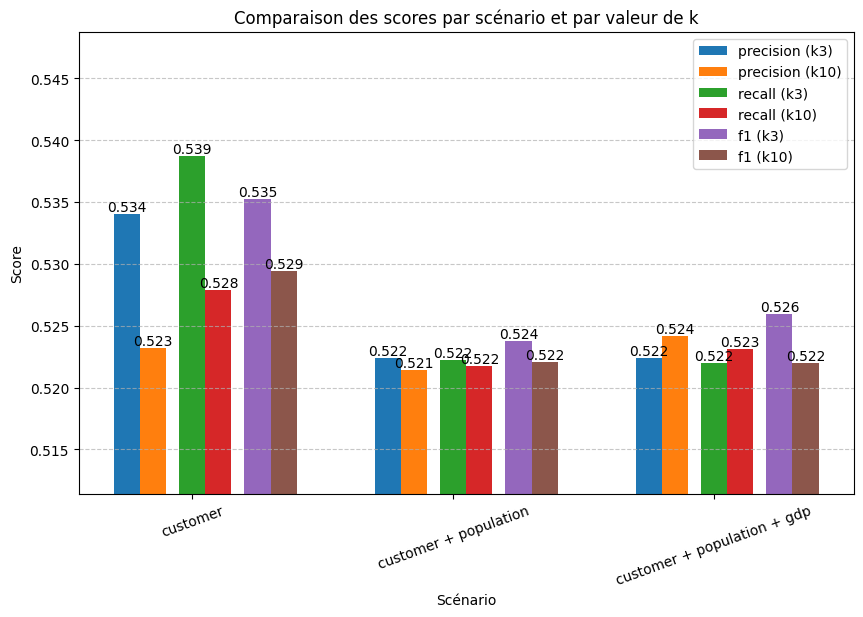

In [97]:
from matplotlib import pyplot as plt


def show_crossval_plot(data, min_val=0):
    data = data["crossval"]
    metrics = ['precision', 'recall', 'f1']
    models = list(data['k3'].keys())
    x = np.arange(len(models))
    width = 0.1
    spacing = 0.25

    fig, ax = plt.subplots(figsize=(10, 6))

    all_scores = []

    for i, metric in enumerate(metrics):
        values_k3 = [data['k3'][model][metric] for model in models]
        values_k10 = [data['k10'][model][metric] for model in models]
        all_scores.extend(values_k3 + values_k10)

        bars_k3 = ax.bar(x + (i - 1) * spacing, values_k3, width, label=f'{metric} (k3)')
        bars_k10 = ax.bar(x + (i - 1) * spacing + width, values_k10, width, label=f'{metric} (k10)')

        for bars in [bars_k3, bars_k10]:
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.3f}',
                        ha='center', va='bottom', fontsize=10)

    ax.set_xlabel("Scénario")
    ax.set_ylabel("Score")
    ax.set_title("Comparaison des scores par scénario et par valeur de k")
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=20)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    min_y = max(min_val, min(all_scores) - 0.01)
    max_y = max(all_scores) + 0.01
    ax.set_ylim(min_y, max_y)

    plt.show()

show_crossval_plot(res_dict, 0.510)

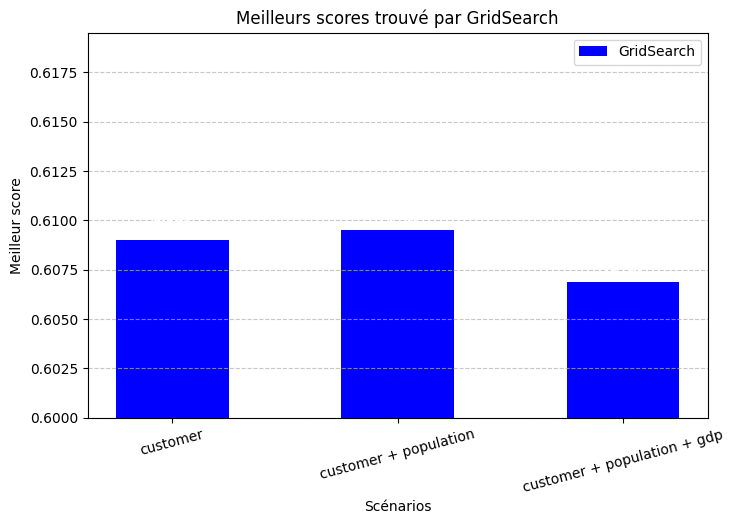

In [102]:

def show_gridsearch_plot(data, min_val=0, k=3):
    models = list(data['gridsearch'][f'k{k}'].keys())
    scores_gridsearch = [data['gridsearch'][f'k{k}'][m]['score'] for m in models]

    x = np.arange(len(models))
    width = 0.5

    fig, ax = plt.subplots(figsize=(8, 5))

    bars_gridsearch = ax.bar(x, scores_gridsearch, width, label='GridSearch', color='blue')

    for i, bar in enumerate(bars_gridsearch):
        height = bar.get_height()
        params = data['gridsearch'][f'k{k}'][models[i]]['params']
        param_text = f"({params['max_depth']}, {params['min_samples_split']})"
        ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.3f}\n{param_text}',
                ha='center', va='bottom', fontsize=9, color='white', fontweight='bold')

    ax.set_xlabel("Scénarios")
    ax.set_ylabel("Meilleur score")
    ax.set_title("Meilleurs scores trouvé par GridSearch")
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=15)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    min_y = max(min_val, min(scores_gridsearch) - 0.01)
    max_y = max(scores_gridsearch) + 0.01
    ax.set_ylim(min_y, max_y)

    plt.show()

show_gridsearch_plot(res_dict, 0.6)

### 2.8
Nous voyons dans le premier graphique que dans la plupart des cas, les scores sont plus élevés lorsque k=3. Nous pouvons également remarquer que customer semble afficher des scores plus élevés, cependant nous verrons par la suite que les résultats sont différents après ajustement des hyperparamètres.

Dans le second graphique, nous voyons que les résultats sont très proches, cependant le scénario dans lequel nous utilisons customer et population affiche un score légèrement plus élevé.

D## 3. Entrainement d'un classeur multiclass

### 3.1
Nous pouvons maintenant entrainer un modèle multiclass. Pour commencer, nous allons discrétiser les revenus en 3 classes : bas, moyen et élevé. Pour cela, nous allons utiliser PowerTransformer pour transformer la distribution des revenus selon les conditions suivantes :
- Bas : revenu < moyenne - écart-type
- Moyen : moyenne - écart-type <= revenu <= moyenne + écart-type
- Élevé : revenu > moyenne + écart-type

In [90]:
from sklearn.preprocessing import PowerTransformer

# Remplacement des valeurs manquantes sur le jeu de données pour préparer la classe
train_set_corrected = replace_missing_values_function(train_set, ["first_item_prize", "revenue"], ["gender", "ReBuy", "country"])

power_transformer = PowerTransformer()
revenue_transformed = power_transformer.fit_transform(train_set_corrected[["revenue"]])

# Calcul des statistiques de la distribution transformée
revenue_mean = revenue_transformed.mean()
revenue_std = revenue_transformed.std()

# Création des classes : bas (0), moyen (1), élevé (2)
customer_labels = np.select(
    [revenue_transformed.flatten() < revenue_mean - revenue_std,
     (revenue_transformed.flatten() >= revenue_mean - revenue_std) & (revenue_transformed.flatten() <= revenue_mean + revenue_std),
     revenue_transformed.flatten() > revenue_mean + revenue_std],
    [0, 1, 2]
)
print("Répartition des classes :", np.bincount(customer_labels))

Répartition des classes : [1329 5268 1403]


### 3.2
Nous allons reprendre les étapes effectuées précédemment pour le classeur binaire.



In [91]:
# Préparation des données d'entrainement
customer_train = resample(train_set, replace=False, n_samples=8000, random_state=42)
customer_train = customer_train.drop("revenue", axis=1)
# Uniquement customer
customer_prepare = prepare_customer(customer_train)
# customer + population
customer_pop_prepare = prepare_customer_pop(customer_train)
# customer + population + gdp
customer_pop_gdp_prepare = prepare_customer_pop_gdp(customer_train)

# Entrainement du modèle
tree_class_customer  = DecisionTreeClassifier()
tree_class_customer_pop  = DecisionTreeClassifier()
tree_class_customer_pop_gdp  = DecisionTreeClassifier()
tree_class_customer.fit(customer_prepare, customer_labels)
tree_class_customer_pop.fit(customer_pop_prepare, customer_labels)
tree_class_customer_pop_gdp.fit(customer_pop_gdp_prepare, customer_labels)

DecisionTreeClassifier()

Maintenant nous pouvons évaluer les performances du modèle avec la validation croisée.

In [92]:
res_dict_multiclass = {
    "crossval": {
        "k3": {},
        "k10": {}
    },
    "gridsearch": {
        "k3": {},
        "k10": {}
    }
}
# Evaluation du modèle pour chaque ensemble de données avec k=3 et k=10
print("Évaluation avec k=3")
print("\nCustomer (k=3):")
res_dict_multiclass["crossval"]["k3"]["customer"] = cross_val_classification_metrics(tree_class_customer, customer_prepare, customer_labels, cv=3)
print("\nCustomer + Population (k=3):")
res_dict_multiclass["crossval"]["k3"]["customer + population"] = cross_val_classification_metrics(tree_class_customer_pop, customer_pop_prepare, customer_labels, cv=3)
print("\nCustomer + Population + GDP (k=3):")
res_dict_multiclass["crossval"]["k3"]["customer + population + gdp"] = cross_val_classification_metrics(tree_class_customer_pop_gdp, customer_pop_gdp_prepare, customer_labels, cv=3)
print("\nÉvaluation avec k=10")
print("\nCustomer (k=10):")
res_dict_multiclass["crossval"]["k10"]["customer"] = cross_val_classification_metrics(tree_class_customer, customer_prepare, customer_labels, cv=10)
print("\nCustomer + Population (k=10):")
res_dict_multiclass["crossval"]["k10"]["customer + population"] = cross_val_classification_metrics(tree_class_customer_pop, customer_pop_prepare, customer_labels, cv=10)
print("\nCustomer + Population + GDP (k=10):")
res_dict_multiclass["crossval"]["k10"]["customer + population + gdp"] = cross_val_classification_metrics(tree_class_customer_pop_gdp, customer_pop_gdp_prepare, customer_labels, cv=10)

Évaluation avec k=3

Customer (k=3):
Précision (k=3): 0.48111648379074884 ± 0.0026342599526135105
Rappel (k=3): 0.4753740459861872 ± 0.006705545851370728
F1-mesure (k=3): 0.4780598611296307 ± 0.005879501993065027

Customer + Population (k=3):
Précision (k=3): 0.4866211728043431 ± 0.0019319279337538706
Rappel (k=3): 0.4820008432929379 ± 0.005433996668516412
F1-mesure (k=3): 0.4849030269545278 ± 0.0016718455526158356

Customer + Population + GDP (k=3):
Précision (k=3): 0.48159861848734503 ± 0.0019322677476865328
Rappel (k=3): 0.47450084305853363 ± 0.0061146301764654284
F1-mesure (k=3): 0.4770072532040281 ± 0.0035652402635285066

Évaluation avec k=10

Customer (k=10):
Précision (k=10): 0.48171989922815583 ± 0.010403848829460376
Rappel (k=10): 0.48324999999999996 ± 0.008388980867781259
F1-mesure (k=10): 0.4787508963986881 ± 0.011552517144012002

Customer + Population (k=10):
Précision (k=10): 0.4855939398417424 ± 0.010588127054017564
Rappel (k=10): 0.483375 ± 0.010518584743205708
F1-mesure

Nous remarquons que cette fois-ci les résultats sont légèrement meilleurs pour k=10.
Nous allons donc passer à l'optimisation des hyperparamètres pour k=10.

In [93]:
grid_search = GridSearchCV(estimator=tree_class, param_grid=param_grid, cv=10, scoring='accuracy')
def grid_search_function(numpy, labels):
    grid_search.fit(numpy, labels)
    # Meilleurs paramètres trouvés
    print("Meilleurs paramètres trouvés : ", grid_search.best_params_)
    # Meilleurs scores
    print("Meilleur score (accuracy) : ", grid_search.best_score_)
    return {
        "params": grid_search.best_params_,
        "score": float(grid_search.best_score_),
    }
print("Customer")
res_dict_multiclass["gridsearch"]["k10"]["customer"] = grid_search_function(customer_prepare, customer_labels)
print("\nCustomer + Population")
res_dict_multiclass["gridsearch"]["k10"]["customer + population"] = grid_search_function(customer_pop_prepare, customer_labels)
print("\nCustomer + Population + GDP")
res_dict_multiclass["gridsearch"]["k10"]["customer + population + gdp"] = grid_search_function(customer_pop_gdp_prepare, customer_labels)

Customer
Meilleurs paramètres trouvés :  {'max_depth': 3, 'min_samples_split': 2}
Meilleur score (accuracy) :  0.656875

Customer + Population
Meilleurs paramètres trouvés :  {'max_depth': 3, 'min_samples_split': 10}
Meilleur score (accuracy) :  0.657375

Customer + Population + GDP
Meilleurs paramètres trouvés :  {'max_depth': 3, 'min_samples_split': 2}
Meilleur score (accuracy) :  0.658625


Les meilleurs paramètres trouvés sont les suivants : max_depth = 3, min_samples_split = 2 dans le cas ou nous prenons les données de customer, population et gdp.

Le meilleur classeur serait donc le suivant :
* dataframe : customer, population et gdp
* k=10
* max_depth : 3
* min_sample_split : 2

Vérifions ça en utilisant des graphiques

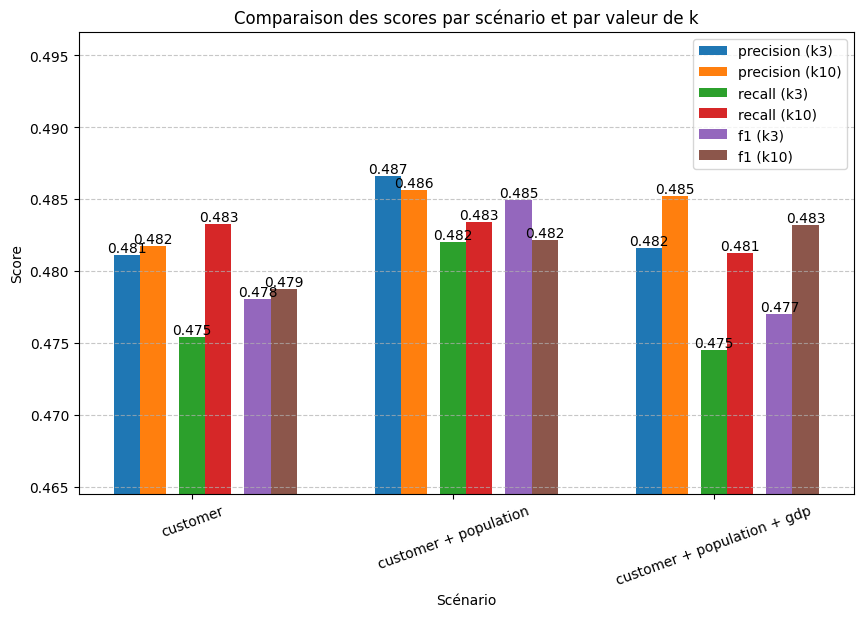

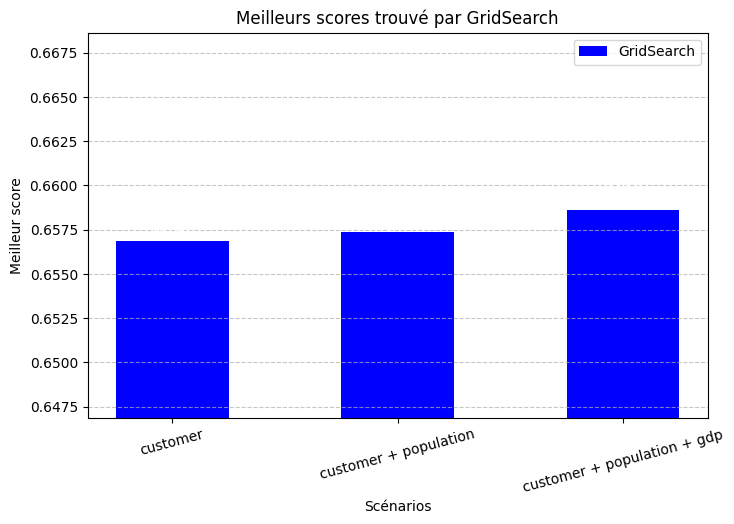

In [103]:
show_crossval_plot(res_dict_multiclass, 0.460)
show_gridsearch_plot(res_dict_multiclass, 0.5, 10)

Nous pouvons voir dans le premier graphique que les scores dans le cas ou k=10 est presque constamment supérieur au score lorsque k=3, confirmant le fait que la meilleur option pour k est 10.

Dans le second graphique on voit que le score le plus élevé est lorsque l'on rassemble les trois dataframe (customer, population et gdp) justifiant le choix de ce scénario.

### 3.3

Afin de comparer le classeur binaire et le classeur multiclass, nous allons tester le classeur multiclass sur le jeu de test.


In [95]:
# Remplacement des valeurs manquantes sur le jeu de données pour préparer la classe
train_set_corrected = replace_missing_values_function(test_set, ["first_item_prize", "revenue"], ["gender", "ReBuy", "country"])

power_transformer = PowerTransformer()
revenue_transformed = power_transformer.fit_transform(train_set_corrected[["revenue"]])

# Calcul des statistiques de la distribution transformée
revenue_mean = revenue_transformed.mean()
revenue_std = revenue_transformed.std()

# Création des classes : bas (0), moyen (1), élevé (2)
customer_labels_test = np.select(
    [revenue_transformed.flatten() < revenue_mean - revenue_std,
     (revenue_transformed.flatten() >= revenue_mean - revenue_std) & (revenue_transformed.flatten() <= revenue_mean + revenue_std),
     revenue_transformed.flatten() > revenue_mean + revenue_std],
    [0, 1, 2]
)

# Traitement des données avec le pipeline
# On redéfinit le pipeline
full_pipeline = ColumnTransformer(
    transformers=[
        ("cleaning", data_cleaning, customer_train.columns),
        ("enrichment", data_enrichment, customer_train.columns),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False), make_column_selector(dtype_include=np.number))
    ],
    remainder="drop"
)
# On entraine ce pipeline avec les données d'entrainement
full_pipeline.fit(customer_train)
# On transforme avec les données de test
res = full_pipeline.transform(customer_test)
customer_pop_prepare_test = remove_non_numeric_columns(res)

#Entrainement du modèle
tree_class_test  = DecisionTreeClassifier()
tree_class_test.fit(customer_pop_prepare_test, customer_labels_test)

print("\nEvaluation sur le jeu de test")
res_dict_multiclass["test"] = cross_val_classification_metrics(tree_class_test, customer_pop_prepare_test, customer_labels_test, cv=3)


Evaluation sur le jeu de test
Précision (k=3): 0.7366248456127261 ± 0.010957004047289474
Rappel (k=3): 0.7374968671820247 ± 0.00964653575239372
F1-mesure (k=3): 0.7292550089130336 ± 0.0031350242010912137


Maintenant que nous avons évalué le model sur le jeu de test, nous pouvons tracer un graphique pour comparer nos resultats avec le classeur binaire.

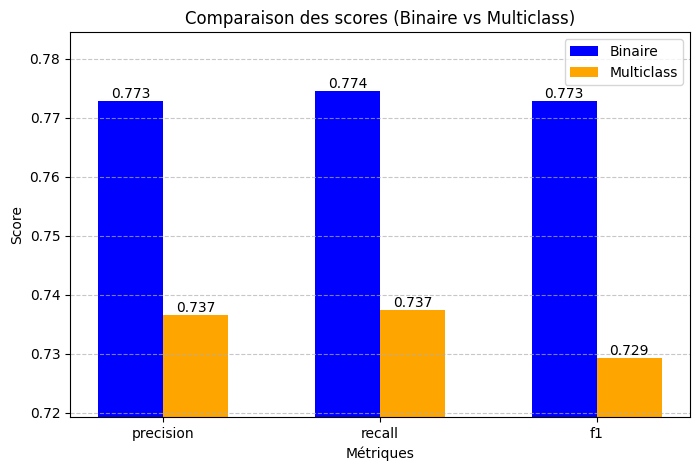

In [96]:
# Extraire les valeurs des métriques
metrics = ['precision', 'recall', 'f1']
values_single = [res_dict["test"][m] for m in metrics]
values_multi = [res_dict_multiclass["test"][m] for m in metrics]

x = np.arange(len(metrics))  # Position sur l'axe X
width = 0.3  # Largeur des barres

fig, ax = plt.subplots(figsize=(8, 5))

# Barres des deux modèles
bars_single = ax.bar(x - width/2, values_single, width, label='Binaire', color='blue')
bars_multi = ax.bar(x + width/2, values_multi, width, label='Multiclass', color='orange')

# Ajouter les valeurs au-dessus des barres
for bars in [bars_single, bars_multi]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.3f}',
                ha='center', va='bottom', fontsize=10)

# Labels et titre
ax.set_xlabel("Métriques")
ax.set_ylabel("Score")
ax.set_title("Comparaison des scores (Binaire vs Multiclass)")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustement des limites Y
min_y = min(min(values_single), min(values_multi)) - 0.01
max_y = max(max(values_single), max(values_multi)) + 0.01
ax.set_ylim(min_y, max_y)

plt.show()

Nous remarquons que le classeur binaire affiche de meilleurs scores que le classeur multiclass, que ce soit pour les scores de précision, de rappel ou f1.

Celà peut être expliqué par plusieurs raisons :

Le classeur multiclass doit pouvoir distinguer plusieurs classes, tandis que le classeur binaire n'a le "choix" qu'entre deux classes distinctes, rendant ainsi la tâche moins complexe.

Aussi, le fait qu'un classeur multiclass ait plusieurs "choix" augmente la probabilité que le modèle se trompe. En effet, dans notre cas, le classeur multiclass à 2 chances sur 3 de se tromper (car 3 classes) et le classeur binaire a 1 chance sur 2.